In [1]:
import os
import nibabel as nib
import numpy as np
from datasets.nifti_dataset import resample_nifti
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
import SimpleITK as sitk
from scipy.ndimage.measurements import center_of_mass
import matplotlib.pyplot as plt

LMKS_FOLDER = "/Volumes/Untitled/PI/CMAC/cMAC/GT/SSFP"
patients = [f"v{p}" for p in range(1, 17) if p != 3]
es_times = [10, 11, 11, 11, 11, 9, 9, 10, 10, 9, 11, 9, 10, 11, 11]
ES = {k: v for (k, v) in zip(patients, es_times)}

/var/folders/39/9622jvw14cxg_gy0jc2cxn_80000gn/T/ipykernel_13921/2488373664.py:8: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


In [9]:
#patients = [f"v{p}" for p in range(9, 10) if p != 3]

def get_motion_error(out_folder, seg):
    images_folder = os.path.join(out_folder, "results", 'images')
    dfield_folder = os.path.join(out_folder, "results", 'dfield', seg)
    error = []
    for patient in patients:
        # Load landmarks
        lmks_folder = f"{LMKS_FOLDER}/{patient}/LMKS_fix/VTK_COORDINATES"
        points = {}
        for t in (0, ES[patient]):
            reader = vtk.vtkGenericDataObjectReader()
            reader.SetFileName(os.path.join(lmks_folder, f"obs1_groundTruth{t:03}.vtk"))
            reader.Update()
            polydata = reader.GetOutput()
            points[t] = dsa.WrapDataObject(polydata).Points
        
        # Load images and dfield
        img = sitk.ReadImage(os.path.join(images_folder, 'volume', f"{patient}.nii.gz"))
        M_nifti = nib.load(os.path.join(images_folder,seg, f"{patient}_seg.nii.gz"))
        dfield = np.load(os.path.join(dfield_folder, f"{patient}_dfield.npy"))
        
        # Get new origin
        M_nifti_resampled = resample_nifti(
            M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16
        )
        center = center_of_mass(M_nifti_resampled.get_fdata()[:, :, :, 0] == 2)
        spacing = np.asarray(img.GetSpacing()[:-1])
        origin = np.asarray(img.GetOrigin()[:-1])
        new_origin = origin

        dfield = dfield.transpose((0, 4, 3, 2, 1))

        print(dfield.shape)

        # For each point in 
        for ed_point, es_point in zip(points[0], points[ES[patient]]):
            index = ((ed_point - new_origin) / spacing).astype(int)
            df = dfield[ES[patient], index[0], index[1], index[2], :]
            moved_point = ed_point + df * spacing
            error.append(np.linalg.norm(moved_point[:-1]-es_point[:-1]))
    return error

(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
Median AEPE error:  3.4814341533785997  ±  2.314814379440147


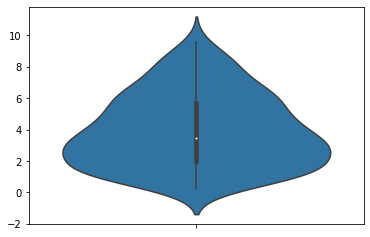

In [3]:
import seaborn as sns
errors = get_motion_error(os.getcwd(), 'our_seg')
print("Median AEPE error: ", np.median(errors), " ± ", np.std(errors))

In [42]:
errors = np.array(get_motion_error(os.getcwd(), 'our_seg')).reshape((15,12))
error_carson = np.array(get_motion_error(os.getcwd(), 'their_seg')).reshape((15,12))

(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)
(30, 256, 256, 16, 3)


In [11]:
np.max(error_carson)

9.990705768206016

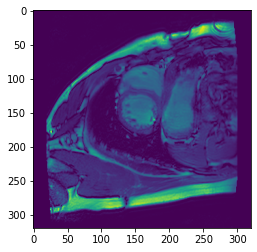

In [76]:
from dipy.align.reslice import reslice
img = nib.load('results/images/volume/v7.nii.gz')
data = img.get_fdata()
zooms = img.header.get_zooms()
#new_zooms = [zooms[0]*data., zooms[1]]
plt.imshow(data[:,:,6,0])

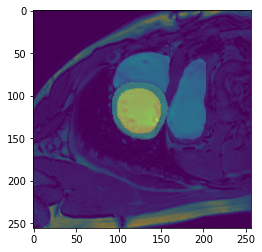

In [78]:
seg = nib.load('results/images/our_seg/v7_seg.nii.gz')
plt.imshow(pad_256x256(data[:,:,6,0]))
plt.imshow(pad_256x256(seg.get_fdata()[:,:,6,0]), alpha=0.5)

In [73]:
np.sum(pad_256x256(data[:,:,6,0]) == data[:,:,6,0])

65536

In [75]:
sitk.GetArrayFromImage(sitk.ReadImage('/Users/yhibo/tensorflow-test/PIStrain/script/MHD_Data/v1/cSAX/v1_cSAX_time_1.mhd')).shape

(14, 256, 256)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from utils.io_utils import cat_read_lmks

#method = 'bspline'
method = 'demons'
use_roi = False
tracking_3d = True
morph_int = False
tracking_edges = True

remove_OFV_plane = False # reduce el error de fuera de plano al solo comparar dos coord. y no las tres.



# NOTE: Al parecer todas las img de cine ssfp el canal donde esta el eje largo
# es z por eso no se usa ba_channel. 
#ba_channels = [1,0,1,0,0,0,1,0,0,0,0,0,0,0,0]
# NOTE: Todas las imagenes tienen la misma orientacion de apex to base y es 0,
# por eso no se usa apex2base
#  apex2base = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
patients =  ['v1','v2','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16']


# NOTE: como no estan alineados de forma temporal los lmks en SSFP vamos solo a
# calcular el error en FF y ES
SSFP_ff = 29 # para todos los pacientes
SSFP_es = [10,11,11,11,11,9,9,10,10,9,11,9,10,11,11]

TAG3D_ff = [22,28,25,22,22,30,30,29,26,31,23,37,28,20,24]
TAG3D_es = [10,10,10,10,10,11,10,10,10,11,10,10,11,8,9]



#diff = []
diff_inria = []
diff_upf = []

#  idp= 0
for idp in range(len(patients)):

    patient = patients[idp]
    ba_channel = 2 
    a2b = 0

    print('Patient {}'.format(patient))


    # Leemos el GT de los lmks acorde al sistema de coordenadas VTK e INRIA
    #lmks
    # NOTE: 1) Por algun motivo no esta bien alineado temporalmente los lmks de
    # Tagging con las imagenes de SSFP. Es por eso que solo se van a analizar
    # los errores en FF y ED. 
    # 2) Por algun motivo no es simple ordenar los lmks en el sistema de INRIA
    # por eso lo vamos a dejar desordenados.

    gt_vtk = cat_read_lmks(patient, ba_channel, a2b, dbtype='ssfp', coord='vtk', sort=True)

    # Solo ordenamos para el nuestro que fueron ordenadas
    #  gt_upf = cat_read_lmks(patient, ba_channel, a2b, dbtype='ssfp',
    #          coord='vtk', sort=True)
    gt_inri = cat_read_lmks(patient, ba_channel, a2b, dbtype='ssfp', coord='inria', sort=False)

    # Leemos los resultados de UPF e INRIA
    upflmks = cat_read_lmks(patient, ba_channel, a2b, dbtype='upf_ssfp', sort=True)
    inrialmks = cat_read_lmks(patient, ba_channel, a2b, dbtype='inria_ssfp', sort=False)

    # Leemos los resultados nuestros que ya estan ordenados siendo los primeros
    # base y los ultimos apex
    # lmks = cat_read_mylmks(patient, dbtype='ssfp', method=method,
    #         tracking_3d=tracking_3d, morph_int=morph_int, use_roi=use_roi,
    #         tracking_edges=tracking_edges, demons_std=demons_std)

    # NOTE; Los lmks del metodo propuesto y UPF estan ordenados de forma que 
    #  0-3: base; 4-7: midd; 8-11: apex

    # diff_i = gt_vtk[..., [TAG3D_es[idp], TAG3D_ff[idp]]] - \
    #         lmks[...,[SSFP_es[idp],SSFP_ff]]
    # NOTE: InRIA por algun motivo arranca el registrado en FF ya que les da
    # igual a los lmks, asi que vamos a tomar FF como el t=0
    diff_inria_i = gt_inri[..., [TAG3D_es[idp], TAG3D_ff[idp]]] - \
            inrialmks[...,[SSFP_es[idp],0]]
    diff_upf_i = gt_vtk[..., [TAG3D_es[idp], TAG3D_ff[idp]]] - \
            upflmks[...,[SSFP_es[idp],SSFP_ff]]

    #diff.append(diff_i)
    diff_inria.append(diff_inria_i)
    diff_upf.append(diff_upf_i)


#diff = np.asarray(diff)
diff_inria = np.asarray(diff_inria)
diff_upf = np.asarray(diff_upf)


#error = np.linalg.norm(diff, axis=3)
error_inria = np.linalg.norm(diff_inria, axis=3)
error_upf = np.linalg.norm(diff_upf, axis=3)



# Calculo de outliers
def get_outliers(x, ql=25, qu=75):
    q1, q3= np.percentile(x,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr)
    upper_bound = q3 +(1.5 * iqr)

    outliers1 = x > upper_bound 
    outliers2 = x < lower_bound 
    outliers = np.hstack([x[outliers2], x[outliers1]])
    return outliers


Patient v1
Patient v2
Patient v4
Patient v5
Patient v6
Patient v7
Patient v8
Patient v9
Patient v10
Patient v11
Patient v12
Patient v13
Patient v14
Patient v15
Patient v16


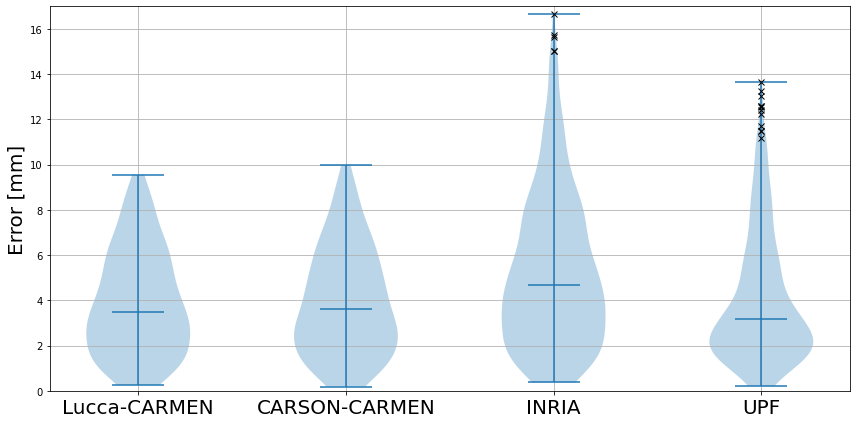

In [43]:
# ---------- Plots configuration
fontsize = 20
fontsize_ticks = 16

# ----------- Plot con el error global
data = [errors.flatten(), error_carson.flatten(), error_inria.flatten(), error_upf.flatten()]
labels = ['Lucca-CARMEN', 'CARSON-CARMEN', 'INRIA', 'UPF']

plt.figure(figsize=(12,6))
plt.violinplot(data,showmeans=False, showextrema=True, showmedians=True)
plt.xticks([1,2, 3, 4],labels, fontsize=fontsize)
plt.ylim(0.,17)
#  plt.yticks(np.arange(0.,1.01,.1), fontsize=fontsize_ticks)
plt.ylabel("Error [mm]", fontsize=fontsize)
plt.grid()

# Outliers
for i in range(len(labels)):
    outliers = get_outliers(data[i])
    plt.plot((i+1)*np.ones(len(outliers)), outliers, 'xk')


plt.tight_layout()

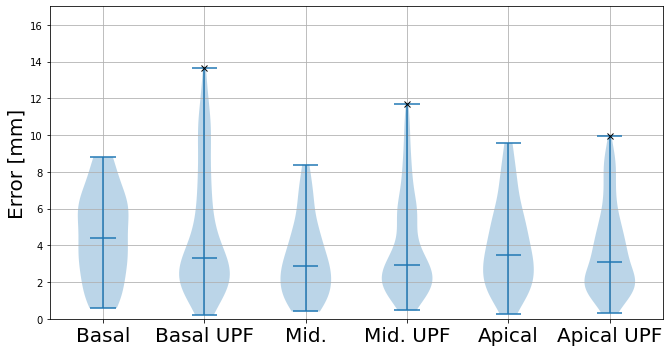

In [45]:
data = [errors[:,0:4].flatten(), error_upf[...,0:4,:].flatten(),
        errors[:,4:8].flatten(), error_upf[...,4:8,:].flatten(),
        errors[:,8:].flatten(), error_upf[...,8:,:].flatten()
        ]
labels = ['Basal', 'Basal UPF', 'Mid.', 'Mid. UPF', 'Apical', 'Apical UPF']

plt.figure(figsize=(9.5,5))
plt.violinplot(data,showmeans=False, showextrema=True, showmedians=True)
plt.xticks(np.r_[1:len(labels)+1],labels, fontsize=fontsize)
plt.ylim(0.,17)
#  plt.yticks(np.arange(0.,1.01,.1), fontsize=fontsize_ticks)
plt.ylabel("Error [mm]", fontsize=fontsize)
plt.grid()

# Outliers
for i in range(len(labels)):
    outliers = get_outliers(data[i])
    plt.plot((i+1)*np.ones(len(outliers)), outliers, 'xk')

plt.tight_layout()

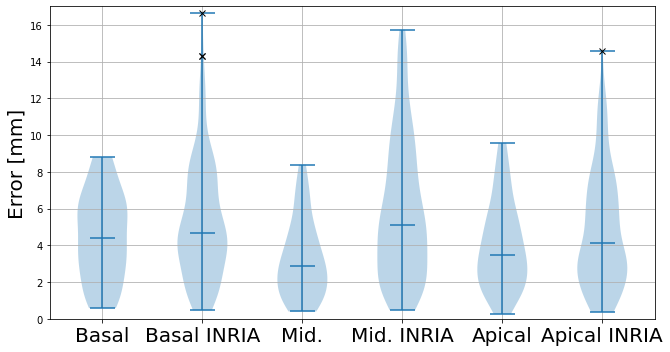

In [46]:
data = [errors[:,0:4].flatten(), error_inria[...,0:4,:].flatten(),
        errors[:,4:8].flatten(), error_inria[...,4:8,:].flatten(),
        errors[:,8:].flatten(), error_inria[...,8:,:].flatten()
        ]
labels = ['Basal', 'Basal INRIA', 'Mid.', 'Mid. INRIA', 'Apical', 'Apical INRIA']

plt.figure(figsize=(9.5,5))
plt.violinplot(data,showmeans=False, showextrema=True, showmedians=True)
plt.xticks(np.r_[1:len(labels)+1],labels, fontsize=fontsize)
plt.ylim(0.,17)
#  plt.yticks(np.arange(0.,1.01,.1), fontsize=fontsize_ticks)
plt.ylabel("Error [mm]", fontsize=fontsize)
plt.grid()

# Outliers
for i in range(len(labels)):
    outliers = get_outliers(data[i])
    plt.plot((i+1)*np.ones(len(outliers)), outliers, 'xk')

plt.tight_layout()